In [2]:
import os
import numpy as np
import librosa
import pandas as pd
from python_speech_features import mfcc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import svm
from scipy.io import wavfile
from sklearn.model_selection import cross_val_score
import soundfile as sf
def calculate_metrics(target, prediction, average='weighted'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]*100:.4f} %')
    print(f'  Precision: {metrics[1]*100:.4f} %')
    print(f'  Recall:    {metrics[2]*100:.4f} %')
    print(f'  F1 score:  {metrics[3]*100:.4f} %')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')
    
def print_min_max(collumn):
    print(f'  Maksimum:  {collumn.max():.4f}')
    print(f'  Minimum:   {collumn.min():.4f}')
    print(f'  Średnia:   {collumn.mean():.4f}')
    print(f'  Mediana:   {collumn.median():.4f}')
    
def Model_poza(My_model,plik_csv):
    final_poza = pd.DataFrame()
    Thatistrue_poza = pd.DataFrame()
    for file in plik_csv['Name'].unique():
        One_person_poza = plik_csv.loc[plik_csv['Name'] == file].drop('Name', axis = 1)
        One_person_poza = scaler_standard.transform(One_person_poza)

        Prediction_poza = My_model.predict(One_person_poza) #tutaj zamieniamy knn na inny model do predykcji

        # Obliczanie na ile osoba sprawdzana jest podobna do samej siebie
        df11_poza = pd.DataFrame(Prediction_poza,columns = ['Ho'])
        df = pd.DataFrame({'Name': file},index=[0])
        final_poza = pd.concat([final_poza, df]).reset_index(drop=True)

        # Obliczanie do kogo osoba sprawdzana jest najbardziej podobna
        hois = df11_poza.value_counts().idxmax()[0]
        howmuch = df11_poza.value_counts(normalize=True).max()*100
        datahow = pd.DataFrame({'Similar to': hois, 'How much [%]': howmuch}, index=[0])
        Thatistrue_poza = pd.concat([Thatistrue_poza, datahow]).reset_index(drop=True)
        #złączenie tabel
        final_form_poza = pd.concat([final_poza,Thatistrue_poza],axis=1)

    display(final_form_poza)
    print_min_max(final_form_poza['How much [%]'])
    
def Model_odtwarzanie(My_model,plik_csv):
    final = pd.DataFrame()
    Thatistrue = pd.DataFrame()
    for file in plik_csv['Name'].unique():
        One_person = plik_csv.loc[plik_csv['Name'] == file].drop('Name', axis = 1)
        One_person = scaler_standard.transform(One_person)

        Prediction = My_model.predict(One_person) #tutaj zamieniamy knn na inny model do predykcji

        # Obliczanie na ile osoba sprawdzana jest podobna do samej siebie
        df11 = pd.DataFrame(Prediction,columns = ['Ho'])
        df_True = df11[df11["Ho"]  == file]
        probability = df_True.size/df11.size*100
        df = pd.DataFrame({'Name': file, 'To himself [%]': probability}, index=[0])
        final = pd.concat([final, df]).reset_index(drop=True)

        # Obliczanie do kogo osoba sprawdzana jest najbardziej podobna
        hois = df11.value_counts().idxmax()[0]
        howmuch = df11.value_counts(normalize=True).max()*100
        datahow = pd.DataFrame({'Similar to': hois, 'How much [%]': howmuch}, index=[0])
        Thatistrue = pd.concat([Thatistrue, datahow]).reset_index(drop=True)
        #złączenie tabel
        final_form = pd.concat([final,Thatistrue],axis=1)
        final_form['Is the same person'] = (final_form['Name'] == final_form['Similar to'])
        final_form['More than >80%'] = (final_form['How much [%]'] >= 80)

    display(final_form) 
    print_min_max(final_form['To himself [%]'])
    

def Model_test(My_model,X_test_my,y_test_my, pred,plik_csv,scaler):
    print_results(calculate_metrics(y_test_my, pred))
    fig, ax = plt.subplots(figsize=(6, 6))
    ConfusionMatrixDisplay.from_estimator(My_model, X_test_my, y_test_my,ax=ax,xticks_rotation= 'vertical')
    plt.title('Confusion matrix')
    plt.show()
    final_test = pd.DataFrame()
    Thatistrue = pd.DataFrame()
    for file in plik_csv['Name'].unique():
        One_person = plik_csv.loc[plik_csv['Name'] == file].drop('Name', axis = 1)
        One_person = scaler.transform(One_person)

        Prediction = My_model.predict(One_person) #tutaj zamieniamy knn na inny model do predykcji

        # Obliczanie na ile osoba sprawdzana jest podobna do samej siebie
        df11 = pd.DataFrame(Prediction,columns = ['Ho'])
        df_True = df11[df11["Ho"]  == file]
        probability = df_True.size/df11.size*100
        df = pd.DataFrame({'Name': file, 'To himself [%]': probability}, index=[0])
        final_test = pd.concat([final_test, df]).reset_index(drop=True)


        # Obliczanie do kogo osoba sprawdzana jest najbardziej podobna
        hois = df11.value_counts().idxmax()[0]
        howmuch = df11.value_counts(normalize=True).max()*100
        datahow = pd.DataFrame({'Similar to': hois, 'How much [%]': howmuch}, index=[0])
        Thatistrue = pd.concat([Thatistrue, datahow]).reset_index(drop=True)
        #złączenie tabel
        final_form = pd.concat([final_test, Thatistrue],axis=1)

    display(final_form) 
    print_min_max(final_form['To himself [%]'])
    
def obrobka_mfcc(path, save):
    final = pd.DataFrame()
    file_list =  os.listdir(path)
    for file in file_list:
        (sr, y) = wavfile.read(path + file) 
        y = y * (1 / np.max(np.abs(y)) )
        clips = librosa.effects.split(y, top_db=20)
        wav_data = []
        for c in clips:
            data = y[c[0]: c[1]]
            wav_data.extend(data)
        sf.write('5s.wav', wav_data, sr)
        (sr, y) = wavfile.read('5s.wav')
        mfcc_feat = mfcc(y, sr,winlen=winlen,winstep=winstep,numcep=numcep,nfilt=nfilt,nfft=nfft,lowfreq=lowfreq,preemph=preemph, ceplifter = ceplifter,appendEnergy=appendEnergy,winfunc=winfunc)
        df_mfcc_feat = pd.DataFrame(mfcc_feat)
        df_mfcc_feat['Name'] = file
        final = pd.concat([final, df_mfcc_feat])
    final.reset_index(drop=True)
    final.to_csv(save+'.csv', index=False)

# Obróbka i wyciąganie cech z plików Audio wraz z zapisem do CSV

In [3]:
winlen = 0.12
winstep = winlen/2
numcep = 22
nfilt = 26
nfft = int(2**14)
lowfreq = 0
preemph = 0.097
appendEnergy = False
ceplifter = 22
winfunc = np.hamming



In [4]:
path_train = "C:\\Users\\akadix\\Inz\\obrobka\\"
path_test = "C:\\Users\\akadix\\Inz\\test\\"
path_poza = "C:\\Users\\akadix\\Inz\\poza\\"
obrobka_mfcc(path_train,"Trenujacy")
obrobka_mfcc(path_test,"Walidacyjny")

# Wczytanie danych z CSV

In [5]:
Final_training = pd.read_csv('Trenujacy.csv')
Final_test = pd.read_csv('Walidacyjny.csv')

# Podział danych

In [6]:
y = Final_training['Name']
x = Final_training.drop('Name', axis = 1)
scaler_standard = StandardScaler()
x = scaler_standard.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(x,y, stratify=y,test_size=0.2,random_state= 3113)

# Regresja logistyczna

Results for classifier
----
  Accuracy:  96.9572 %
  Precision: 96.9738 %
  Recall:    96.9572 %
  F1 score:  96.9592 %
  Mislabeled 59 out of 1939




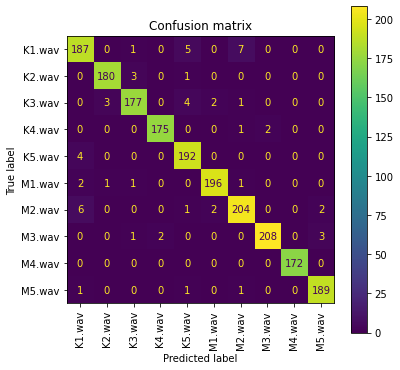

,Name,To himself [%],Similar to,How much [%]
0,K1.wav,81.578947,K1.wav,81.578947
1,K2.wav,93.023256,K2.wav,93.023256
2,K3.wav,87.755102,K3.wav,87.755102
3,K4.wav,97.872340,K4.wav,97.872340
4,K5.wav,90.909091,K5.wav,90.909091
5,M1.wav,91.071429,M1.wav,91.071429
6,M2.wav,66.666667,M2.wav,66.666667
7,M3.wav,85.294118,M3.wav,85.294118
8,M4.wav,80.645161,M4.wav,80.645161
9,M5.wav,87.878788,M5.wav,87.878788


  Maksimum:  97.8723
  Minimum:   66.6667
  Średnia:   86.2695
  Mediana:   87.8169


In [7]:
from sklearn.linear_model import LogisticRegression
logreg_clf = LogisticRegression(solver='lbfgs', max_iter=200, C=0.7,multi_class='multinomial')
logreg_clf.fit(X_train,y_train)
pred_logreg = logreg_clf.predict(X_test)
Model_test(logreg_clf,X_test,y_test, pred_logreg,Final_test,scaler_standard)

# KNN

Results for classifier
----
  Accuracy:  97.1635 %
  Precision: 97.2464 %
  Recall:    97.1635 %
  F1 score:  97.1727 %
  Mislabeled 55 out of 1939




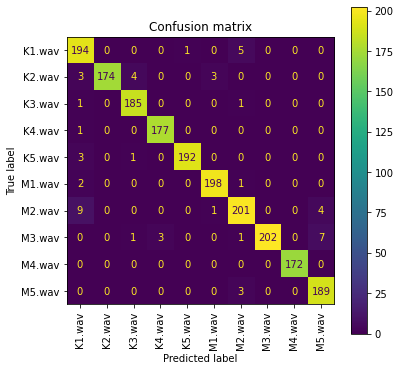

,Name,To himself [%],Similar to,How much [%]
0,K1.wav,84.210526,K1.wav,84.210526
1,K2.wav,90.697674,K2.wav,90.697674
2,K3.wav,93.877551,K3.wav,93.877551
3,K4.wav,82.978723,K4.wav,82.978723
4,K5.wav,100.000000,K5.wav,100.000000
5,M1.wav,94.642857,M1.wav,94.642857
6,M2.wav,92.307692,M2.wav,92.307692
7,M3.wav,97.058824,M3.wav,97.058824
8,M4.wav,93.548387,M4.wav,93.548387
9,M5.wav,84.848485,M5.wav,84.848485


  Maksimum:  100.0000
  Minimum:   82.9787
  Średnia:   91.4171
  Mediana:   92.9280


In [8]:
knn = KNeighborsClassifier(n_neighbors =3,weights="distance", metric = "euclidean")
knn.fit(X_train,y_train)
pred_knn = knn.predict(X_test)
Model_test(knn,X_test,y_test, pred_knn,Final_test,scaler_standard)

# SVM

Results for classifier
----
  Accuracy:  97.3182 %
  Precision: 97.3315 %
  Recall:    97.3182 %
  F1 score:  97.3214 %
  Mislabeled 52 out of 1939




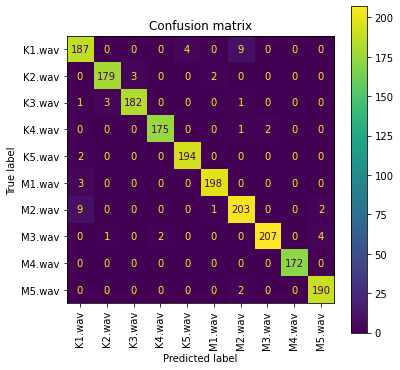

,Name,To himself [%],Similar to,How much [%]
0,K1.wav,81.578947,K1.wav,81.578947
1,K2.wav,93.023256,K2.wav,93.023256
2,K3.wav,93.877551,K3.wav,93.877551
3,K4.wav,82.978723,K4.wav,82.978723
4,K5.wav,96.969697,K5.wav,96.969697
5,M1.wav,96.428571,M1.wav,96.428571
6,M2.wav,87.179487,M2.wav,87.179487
7,M3.wav,100.000000,M3.wav,100.000000
8,M4.wav,90.322581,M4.wav,90.322581
9,M5.wav,96.969697,M5.wav,96.969697


  Maksimum:  100.0000
  Minimum:   81.5789
  Średnia:   91.9329
  Mediana:   93.4504


In [9]:
svm_clf = svm.SVC(kernel='rbf',C = 0.2, gamma = 'auto') 
svm_clf.fit(X_train, y_train)
pred_SVM = svm_clf.predict(X_test)
Model_test(svm_clf,X_test,y_test,pred_SVM,Final_test,scaler_standard)

# Drzewo decyzyjne

Results for classifier
----
  Accuracy:  79.5771 %
  Precision: 79.7811 %
  Recall:    79.5771 %
  F1 score:  79.6225 %
  Mislabeled 396 out of 1939




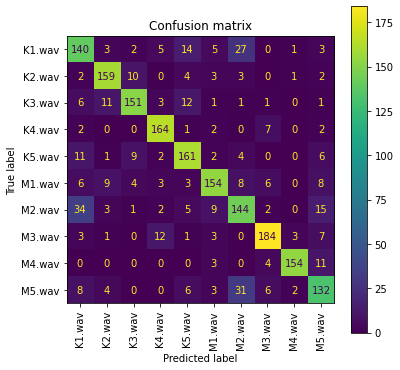

,Name,To himself [%],Similar to,How much [%]
0,K1.wav,57.894737,K1.wav,57.894737
1,K2.wav,76.744186,K2.wav,76.744186
2,K3.wav,73.469388,K3.wav,73.469388
3,K4.wav,87.234043,K4.wav,87.234043
4,K5.wav,72.727273,K5.wav,72.727273
5,M1.wav,53.571429,M1.wav,53.571429
6,M2.wav,51.282051,M2.wav,51.282051
7,M3.wav,94.117647,M3.wav,94.117647
8,M4.wav,48.387097,M4.wav,48.387097
9,M5.wav,78.787879,M5.wav,78.787879


  Maksimum:  94.1176
  Minimum:   48.3871
  Średnia:   69.4216
  Mediana:   73.0983


In [10]:
from sklearn import tree
MyTree = tree.DecisionTreeClassifier(criterion = "entropy",splitter="best")
MyTree.fit(X_train, y_train)
pred_tree = MyTree.predict(X_test)
Model_test(MyTree,X_test,y_test,pred_tree,Final_test,scaler_standard)

# Lasy losowe

Results for classifier
----
  Accuracy:  95.1006 %
  Precision: 95.1093 %
  Recall:    95.1006 %
  F1 score:  95.0893 %
  Mislabeled 95 out of 1939




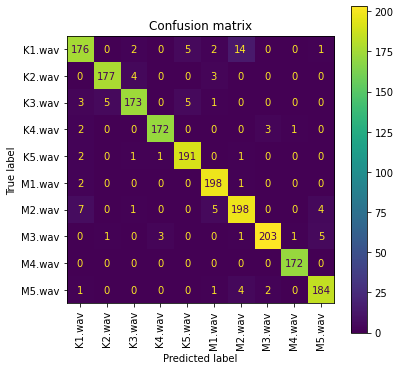

,Name,To himself [%],Similar to,How much [%]
0,K1.wav,68.421053,K1.wav,68.421053
1,K2.wav,90.697674,K2.wav,90.697674
2,K3.wav,89.795918,K3.wav,89.795918
3,K4.wav,85.106383,K4.wav,85.106383
4,K5.wav,90.909091,K5.wav,90.909091
5,M1.wav,85.714286,M1.wav,85.714286
6,M2.wav,89.743590,M2.wav,89.743590
7,M3.wav,97.058824,M3.wav,97.058824
8,M4.wav,77.419355,M4.wav,77.419355
9,M5.wav,81.818182,M5.wav,81.818182


  Maksimum:  97.0588
  Minimum:   68.4211
  Średnia:   85.6684
  Mediana:   87.7289


In [11]:
from sklearn.ensemble import RandomForestClassifier
randomF = RandomForestClassifier(criterion="entropy",n_estimators=80)
randomF.fit(X_train, y_train)
pred_randomf = randomF.predict(X_test)
Model_test(randomF,X_test,y_test,pred_randomf,Final_test,scaler_standard)

# MLP

Results for classifier
----
  Accuracy:  95.4616 %
  Precision: 95.5142 %
  Recall:    95.4616 %
  F1 score:  95.4661 %
  Mislabeled 88 out of 1939




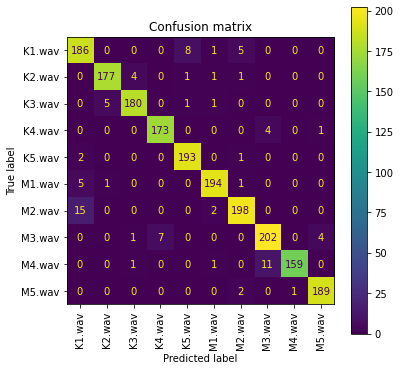

,Name,To himself [%],Similar to,How much [%]
0,K1.wav,81.578947,K1.wav,81.578947
1,K2.wav,83.720930,K2.wav,83.720930
2,K3.wav,85.714286,K3.wav,85.714286
3,K4.wav,95.744681,K4.wav,95.744681
4,K5.wav,87.878788,K5.wav,87.878788
5,M1.wav,82.142857,M1.wav,82.142857
6,M2.wav,87.179487,M2.wav,87.179487
7,M3.wav,91.176471,M3.wav,91.176471
8,M4.wav,83.870968,M4.wav,83.870968
9,M5.wav,96.969697,M5.wav,96.969697


  Maksimum:  96.9697
  Minimum:   81.5789
  Średnia:   87.5977
  Mediana:   86.4469


In [13]:
# Import MLPClassifer
from sklearn.neural_network import MLPClassifier
# Create model object
MLP = MLPClassifier(hidden_layer_sizes=(5,5),
                    activation = "relu",
                    random_state= 5,
                    verbose=False,
                    learning_rate_init=0.01)
# Fit data onto the model
MLP.fit(X_train,y_train)
# Make prediction on test dataset
ypred=MLP.predict(X_test)
Model_test(MLP,X_test,y_test,ypred,Final_test,scaler_standard)

# Badania

## Odporność systemu na odtwarzane nagranie

In [179]:
path_glosnik = "C:\\Users\\akadix\\Inz\\glosnik\\"
obrobka_mfcc(path_glosnik,"glosnik")
Final_glosnik = pd.read_csv('glosnik.csv')

path_telefon = "C:\\Users\\akadix\\Inz\\telefon\\"
obrobka_mfcc(path_telefon,"telefon")
Final_telefon = pd.read_csv('telefon.csv')

### KNN

### nagranie odtwarzane z głośnika

In [180]:
Model_odtwarzanie(knn,Final_glosnik)

,Name,To himself [%],Similar to,How much [%],Is the same person,More than >80%
0,K1.wav,45.714286,K1.wav,45.714286,True,False
1,K2.wav,83.783784,K2.wav,83.783784,True,True
2,K3.wav,82.352941,K3.wav,82.352941,True,True
3,K4.wav,0.000000,K3.wav,43.902439,False,False
4,K5.wav,2.777778,K3.wav,33.333333,False,False
5,M1.wav,85.416667,M1.wav,85.416667,True,True
6,M2.wav,83.333333,M2.wav,83.333333,True,True
7,M3.wav,17.142857,M2.wav,22.857143,False,False
8,M4.wav,81.578947,M4.wav,81.578947,True,True
9,M5.wav,54.285714,M5.wav,54.285714,True,False


  Maksimum:  85.4167
  Minimum:   0.0000
  Średnia:   53.6386
  Mediana:   67.9323


### nagranie odtwarzane z telefonu

In [181]:
Model_odtwarzanie(knn,Final_telefon)

,Name,To himself [%],Similar to,How much [%],Is the same person,More than >80%
0,K1.wav,37.500000,K1.wav,37.500000,True,False
1,K2.wav,67.272727,K2.wav,67.272727,True,False
2,K3.wav,97.142857,K3.wav,97.142857,True,True
3,K4.wav,1.923077,K1.wav,38.461538,False,False
4,K5.wav,15.789474,K3.wav,63.157895,False,False
5,M1.wav,66.666667,M1.wav,66.666667,True,False
6,M2.wav,93.023256,M2.wav,93.023256,True,True
7,M3.wav,5.555556,M2.wav,33.333333,False,False
8,M4.wav,92.307692,M4.wav,92.307692,True,True
9,M5.wav,59.375000,M5.wav,59.375000,True,False


  Maksimum:  97.1429
  Minimum:   1.9231
  Średnia:   53.6556
  Mediana:   63.0208


### SVM

### nagranie odtwarzane z głośnika

In [182]:
Model_odtwarzanie(svm_clf,Final_glosnik)


,Name,To himself [%],Similar to,How much [%],Is the same person,More than >80%
0,K1.wav,22.857143,K3.wav,48.571429,False,False
1,K2.wav,97.297297,K2.wav,97.297297,True,True
2,K3.wav,88.235294,K3.wav,88.235294,True,True
3,K4.wav,0.000000,K3.wav,53.658537,False,False
4,K5.wav,19.444444,K3.wav,30.555556,False,False
5,M1.wav,87.500000,M1.wav,87.500000,True,True
6,M2.wav,52.777778,M2.wav,52.777778,True,False
7,M3.wav,57.142857,M3.wav,57.142857,True,False
8,M4.wav,84.210526,M4.wav,84.210526,True,True
9,M5.wav,74.285714,M5.wav,74.285714,True,False


  Maksimum:  97.2973
  Minimum:   0.0000
  Średnia:   58.3751
  Mediana:   65.7143


### nagranie odtwarzane z telefonu

In [183]:
Model_odtwarzanie(svm_clf,Final_telefon)

,Name,To himself [%],Similar to,How much [%],Is the same person,More than >80%
0,K1.wav,12.500000,K3.wav,46.428571,False,False
1,K2.wav,96.363636,K2.wav,96.363636,True,True
2,K3.wav,91.428571,K3.wav,91.428571,True,True
3,K4.wav,0.000000,K3.wav,53.846154,False,False
4,K5.wav,15.789474,K3.wav,68.421053,False,False
5,M1.wav,44.444444,M1.wav,44.444444,True,False
6,M2.wav,62.790698,M2.wav,62.790698,True,False
7,M3.wav,0.000000,K3.wav,58.333333,False,False
8,M4.wav,82.051282,M4.wav,82.051282,True,True
9,M5.wav,75.000000,M5.wav,75.000000,True,False


  Maksimum:  96.3636
  Minimum:   0.0000
  Średnia:   48.0368
  Mediana:   53.6176


## Weryfikacja osób z poza bazy danych

In [202]:
path_poza = "C:\\Users\\akadix\\Inz\\poza\\"
obrobka_mfcc(path_poza,"Poza")
Final_poza = pd.read_csv('Poza.csv')

### KNN

In [203]:
Model_poza(knn,Final_poza)

,Name,Similar to,How much [%]
0,Poza_K1.wav,K3.wav,41.176471
1,Poza_K2.wav,K1.wav,35.135135
2,Poza_K3.wav,K1.wav,52.380952
3,Poza_K4.wav,M2.wav,55.555556
4,Poza_K5.wav,K1.wav,52.459016
5,Poza_M1.wav,K3.wav,31.111111
6,Poza_M2.wav,M2.wav,60.975610
7,Poza_M3.wav,M2.wav,60.493827
8,Poza_M4.wav,M2.wav,43.298969
9,Poza_M5.wav,M2.wav,68.571429


  Maksimum:  68.5714
  Minimum:   31.1111
  Średnia:   50.1158
  Mediana:   52.4200


### SVM

In [204]:
Model_poza(svm_clf,Final_poza)

,Name,Similar to,How much [%]
0,Poza_K1.wav,K2.wav,47.058824
1,Poza_K2.wav,K1.wav,40.540541
2,Poza_K3.wav,K2.wav,36.904762
3,Poza_K4.wav,M2.wav,55.555556
4,Poza_K5.wav,K1.wav,41.803279
5,Poza_M1.wav,M1.wav,40.000000
6,Poza_M2.wav,M2.wav,41.463415
7,Poza_M3.wav,M2.wav,33.333333
8,Poza_M4.wav,M2.wav,36.082474
9,Poza_M5.wav,M2.wav,60.000000


  Maksimum:  60.0000
  Minimum:   33.3333
  Średnia:   43.2742
  Mediana:   41.0020


## Wpływ częstotliwości próbkowania na weryfikację

### 22050

In [22]:
path_train_22050 = "C:\\Users\\akadix\\Inz\\obrobka_22050\\"
path_test_22050 = "C:\\Users\\akadix\\Inz\\test_22050\\"

obrobka_mfcc(path_train_22050,"Trenujacy_22050")
obrobka_mfcc(path_test_22050,"Walidacyjny_22050")

Final_training_22050 = pd.read_csv('Trenujacy_22050.csv')
Final_test_22050 = pd.read_csv('Walidacyjny_22050.csv')

y_22050 = Final_training_22050['Name']
x_22050 = Final_training_22050.drop('Name', axis = 1)
scaler_standard_22050 = StandardScaler()
x_22050 = scaler_standard_22050.fit_transform(x_22050)
    
X_train_22050, X_test_22050, y_train_22050, y_test_22050 = train_test_split(x_22050,y_22050, stratify=y_22050,test_size=0.2,random_state= 3113)

C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\502861853.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\502861853.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\502861853.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\502861853.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\502861853.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\502861853.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read

# KNN

Results for classifier
----
  Accuracy:  94.6875 %
  Precision: 94.7538 %
  Recall:    94.6875 %
  F1 score:  94.6562 %
  Mislabeled 119 out of 2240




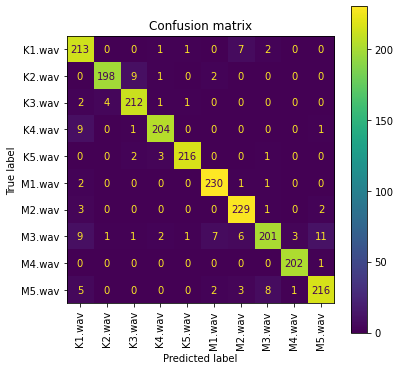

,Name,To himself [%],Similar to,How much [%]
0,K1.wav,87.179487,K1.wav,87.179487
1,K2.wav,90.196078,K2.wav,90.196078
2,K3.wav,90.566038,K3.wav,90.566038
3,K4.wav,56.862745,K4.wav,56.862745
4,K5.wav,94.444444,K5.wav,94.444444
5,M1.wav,73.015873,M1.wav,73.015873
6,M2.wav,81.818182,M2.wav,81.818182
7,M3.wav,77.500000,M3.wav,77.500000
8,M4.wav,75.675676,M4.wav,75.675676
9,M5.wav,86.486486,M5.wav,86.486486


  Maksimum:  94.4444
  Minimum:   56.8627
  Średnia:   81.3745
  Mediana:   84.1523


In [23]:
knn_22050 = KNeighborsClassifier(n_neighbors =5,weights="distance",algorithm='ball_tree', p=2)
knn_22050.fit(X_train_22050,y_train_22050)
pred_knn_22050 = knn_22050.predict(X_test_22050)

Model_test(knn_22050,X_test_22050,y_test_22050,pred_knn_22050,Final_test_22050,scaler_standard_22050)

# SVM

Results for classifier
----
  Accuracy:  94.5089 %
  Precision: 94.5503 %
  Recall:    94.5089 %
  F1 score:  94.5043 %
  Mislabeled 123 out of 2240




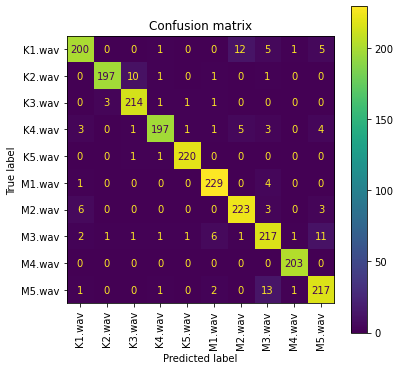

,Name,To himself [%],Similar to,How much [%]
0,K1.wav,76.923077,K1.wav,76.923077
1,K2.wav,94.117647,K2.wav,94.117647
2,K3.wav,90.566038,K3.wav,90.566038
3,K4.wav,39.215686,K4.wav,39.215686
4,K5.wav,88.888889,K5.wav,88.888889
5,M1.wav,71.428571,M1.wav,71.428571
6,M2.wav,79.545455,M2.wav,79.545455
7,M3.wav,82.500000,M3.wav,82.500000
8,M4.wav,67.567568,M4.wav,67.567568
9,M5.wav,81.081081,M5.wav,81.081081


  Maksimum:  94.1176
  Minimum:   39.2157
  Średnia:   77.1834
  Mediana:   80.3133


In [24]:
svm_clf_22050 = svm.SVC(kernel='rbf',C = 0.1, gamma = 'auto',random_state = 11) 
svm_clf_22050.fit(X_train_22050, y_train_22050)
pred_SVM_22050 = svm_clf_22050.predict(X_test_22050)
Model_test(svm_clf_22050,X_test_22050,y_test_22050,pred_SVM_22050,Final_test_22050,scaler_standard_22050)

# 8000

In [26]:
path_train_8000 = "C:\\Users\\akadix\\Inz\\obrobka_8000\\"
path_test_8000 = "C:\\Users\\akadix\\Inz\\test_8000\\"

obrobka_mfcc(path_train_8000,"Trenujacy_8000")
obrobka_mfcc(path_test_8000,"Walidacyjny_8000")

Final_training_8000 = pd.read_csv('Trenujacy_8000.csv')
Final_test_8000 = pd.read_csv('Walidacyjny_8000.csv')

y_8000 = Final_training_8000['Name']
x_8000 = Final_training_8000.drop('Name', axis = 1)
scaler_standard_8000 = StandardScaler()
x_8000 = scaler_standard_8000.fit_transform(x_8000)
    
X_train_8000, X_test_8000, y_train_8000, y_test_8000 = train_test_split(x_8000,y_8000, stratify=y_8000,test_size=0.2,random_state= 3113)

C:\Users\akadix\AppData\Local\Temp\ipykernel_11664\502861853.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_11664\502861853.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_11664\502861853.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_11664\502861853.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_11664\502861853.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_11664\502861853.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read

# KNN

Results for classifier
----
  Accuracy:  92.6476 %
  Precision: 92.7504 %
  Recall:    92.6476 %
  F1 score:  92.6281 %
  Mislabeled 193 out of 2625




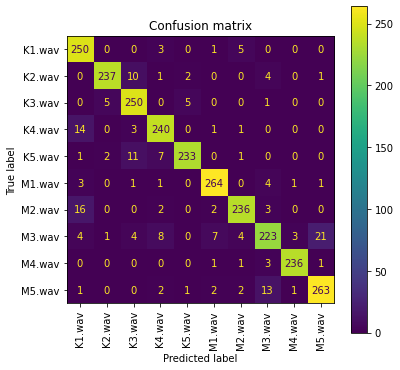

,Name,To himself [%],Similar to,How much [%]
0,K1.wav,68.292683,K1.wav,68.292683
1,K2.wav,91.044776,K2.wav,91.044776
2,K3.wav,79.661017,K3.wav,79.661017
3,K4.wav,31.666667,K1.wav,51.666667
4,K5.wav,87.500000,K5.wav,87.500000
5,M1.wav,58.904110,M1.wav,58.904110
6,M2.wav,65.306122,M2.wav,65.306122
7,M3.wav,69.565217,M3.wav,69.565217
8,M4.wav,70.212766,M4.wav,70.212766
9,M5.wav,75.000000,M5.wav,75.000000


  Maksimum:  91.0448
  Minimum:   31.6667
  Średnia:   69.7153
  Mediana:   69.8890


In [27]:
knn_8000 = KNeighborsClassifier(n_neighbors =5,weights="distance",algorithm='ball_tree', p=2)
knn_8000.fit(X_train_8000,y_train_8000)
pred_knn_8000 = knn_8000.predict(X_test_8000)

Model_test(knn_8000,X_test_8000,y_test_8000,pred_knn_8000,Final_test_8000,scaler_standard_8000)

# SVM

Results for classifier
----
  Accuracy:  91.4667 %
  Precision: 91.5132 %
  Recall:    91.4667 %
  F1 score:  91.4609 %
  Mislabeled 224 out of 2625




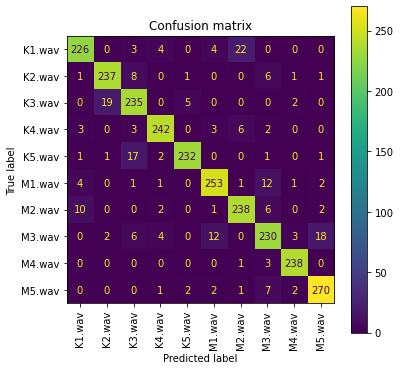

,Name,To himself [%],Similar to,How much [%]
0,K1.wav,68.292683,K1.wav,68.292683
1,K2.wav,91.044776,K2.wav,91.044776
2,K3.wav,86.440678,K3.wav,86.440678
3,K4.wav,33.333333,K1.wav,40.000000
4,K5.wav,85.000000,K5.wav,85.000000
5,M1.wav,57.534247,M1.wav,57.534247
6,M2.wav,51.020408,M2.wav,51.020408
7,M3.wav,67.391304,M3.wav,67.391304
8,M4.wav,65.957447,M4.wav,65.957447
9,M5.wav,72.727273,M5.wav,72.727273


  Maksimum:  91.0448
  Minimum:   33.3333
  Średnia:   67.8742
  Mediana:   67.8420


In [28]:
svm_clf_8000 = svm.SVC(kernel='rbf',C = 0.1, gamma = 'auto',random_state = 11) 
svm_clf_8000.fit(X_train_8000, y_train_8000)
pred_SVM_8000 = svm_clf_8000.predict(X_test_8000)
Model_test(svm_clf_8000,X_test_8000,y_test_8000,pred_SVM_8000,Final_test_8000,scaler_standard_8000)

# Wpływ dźwięków środowiska

In [206]:
path_klawiatura = "C:\\Users\\akadix\\Inz\\klawiatura\\"
obrobka_mfcc(path_klawiatura,"klawiatura")
Final_klawiatura = pd.read_csv('klawiatura.csv')

C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\3189741162.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\3189741162.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\3189741162.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\3189741162.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\3189741162.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\3189741162.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfil

In [207]:
Model_odtwarzanie(knn,Final_klawiatura)
Model_odtwarzanie(svm_clf,Final_klawiatura)

,Name,To himself [%],Similar to,How much [%],Is the same person,More than >80%
0,K1.wav,33.333333,M2.wav,62.500000,False,False
1,K2.wav,62.500000,K2.wav,62.500000,True,False
2,K3.wav,67.924528,K3.wav,67.924528,True,False
3,K4.wav,3.174603,M2.wav,49.206349,False,False
4,K5.wav,48.780488,K5.wav,48.780488,True,False
5,M1.wav,52.307692,M1.wav,52.307692,True,False
6,M2.wav,83.673469,M2.wav,83.673469,True,True
7,M3.wav,8.695652,M2.wav,60.869565,False,False
8,M4.wav,37.500000,M2.wav,50.000000,False,False
9,M5.wav,25.490196,M2.wav,47.058824,False,False


  Maksimum:  83.6735
  Minimum:   3.1746
  Średnia:   42.3380
  Mediana:   43.1402


,Name,To himself [%],Similar to,How much [%],Is the same person,More than >80%
0,K1.wav,22.916667,M2.wav,70.833333,False,False
1,K2.wav,80.357143,K2.wav,80.357143,True,True
2,K3.wav,49.056604,K3.wav,49.056604,True,False
3,K4.wav,1.587302,M2.wav,41.269841,False,False
4,K5.wav,46.341463,K5.wav,46.341463,True,False
5,M1.wav,69.230769,M1.wav,69.230769,True,False
6,M2.wav,89.795918,M2.wav,89.795918,True,True
7,M3.wav,4.347826,M2.wav,60.869565,False,False
8,M4.wav,20.833333,M2.wav,54.166667,False,False
9,M5.wav,29.411765,M2.wav,60.784314,False,False


  Maksimum:  89.7959
  Minimum:   1.5873
  Średnia:   41.3879
  Mediana:   37.8766


In [209]:
path_telewizor = "C:\\Users\\akadix\\Inz\\telewizor\\"
obrobka_mfcc(path_telewizor,"telewizor")
Final_telewizor = pd.read_csv('telewizor.csv')

C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\3189741162.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\3189741162.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\3189741162.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\3189741162.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\3189741162.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\3189741162.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfil

In [210]:
Model_odtwarzanie(knn,Final_telewizor)
Model_odtwarzanie(svm_clf,Final_telewizor)

,Name,To himself [%],Similar to,How much [%],Is the same person,More than >80%
0,K1.wav,78.688525,K1.wav,78.688525,True,False
1,K2.wav,16.129032,K1.wav,49.462366,False,False
2,K3.wav,39.705882,K3.wav,39.705882,True,False
3,K4.wav,3.409091,K1.wav,47.727273,False,False
4,K5.wav,23.076923,K1.wav,53.846154,False,False
5,M1.wav,35.294118,K1.wav,41.176471,False,False
6,M2.wav,46.031746,K1.wav,47.619048,False,False
7,M3.wav,0.000000,M2.wav,49.230769,False,False
8,M4.wav,3.703704,K1.wav,46.913580,False,False
9,M5.wav,7.317073,M2.wav,56.097561,False,False


  Maksimum:  78.6885
  Minimum:   0.0000
  Średnia:   25.3356
  Mediana:   19.6030


,Name,To himself [%],Similar to,How much [%],Is the same person,More than >80%
0,K1.wav,90.163934,K1.wav,90.163934,True,True
1,K2.wav,27.956989,K1.wav,40.860215,False,False
2,K3.wav,47.058824,K3.wav,47.058824,True,False
3,K4.wav,0.000000,K1.wav,79.545455,False,False
4,K5.wav,19.230769,K1.wav,63.461538,False,False
5,M1.wav,40.000000,K1.wav,52.941176,False,False
6,M2.wav,25.396825,K1.wav,65.079365,False,False
7,M3.wav,0.000000,M2.wav,50.769231,False,False
8,M4.wav,1.234568,K1.wav,41.975309,False,False
9,M5.wav,3.658537,M2.wav,57.317073,False,False


  Maksimum:  90.1639
  Minimum:   0.0000
  Średnia:   25.4700
  Mediana:   22.3138


In [212]:
path_ulica = "C:\\Users\\akadix\\Inz\\ulica\\"
obrobka_mfcc(path_ulica,"ulica")
Final_ulica = pd.read_csv('ulica.csv')

C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\3189741162.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\3189741162.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\3189741162.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\3189741162.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\3189741162.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_26812\3189741162.py:134: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfil

In [213]:
Model_odtwarzanie(knn,Final_ulica)
Model_odtwarzanie(svm_clf,Final_ulica)

,Name,To himself [%],Similar to,How much [%],Is the same person,More than >80%
0,K1.wav,1.587302,M2.wav,98.412698,False,True
1,K2.wav,0.000000,M2.wav,74.489796,False,False
2,K3.wav,4.347826,M2.wav,85.507246,False,True
3,K4.wav,2.040816,M2.wav,63.265306,False,False
4,K5.wav,5.454545,M2.wav,80.000000,False,True
5,M1.wav,21.428571,M2.wav,76.530612,False,False
6,M2.wav,93.939394,M2.wav,93.939394,True,True
7,M3.wav,2.941176,M2.wav,82.352941,False,True
8,M4.wav,1.136364,M2.wav,89.772727,False,True
9,M5.wav,1.149425,M2.wav,82.758621,False,True


  Maksimum:  93.9394
  Minimum:   0.0000
  Średnia:   13.4025
  Mediana:   2.4910


,Name,To himself [%],Similar to,How much [%],Is the same person,More than >80%
0,K1.wav,4.761905,M2.wav,95.238095,False,True
1,K2.wav,0.000000,M2.wav,70.408163,False,False
2,K3.wav,13.043478,M2.wav,62.318841,False,False
3,K4.wav,3.061224,M2.wav,64.285714,False,False
4,K5.wav,1.818182,M2.wav,83.636364,False,True
5,M1.wav,40.816327,M2.wav,55.102041,False,False
6,M2.wav,93.939394,M2.wav,93.939394,True,True
7,M3.wav,1.470588,M2.wav,92.647059,False,True
8,M4.wav,0.000000,M2.wav,68.181818,False,False
9,M5.wav,1.149425,M2.wav,93.103448,False,True


  Maksimum:  93.9394
  Minimum:   0.0000
  Średnia:   16.0061
  Mediana:   2.4397
